# Machine Learning Implementation

## Imports

In [1]:
import itertools
import json
import logging

import graphviz
import numpy as np
import pandas as pd
import plotly.offline as py
from graphviz import Digraph
from IPython.display import display
from plotly import graph_objects as go
from scipy.special import logsumexp, expit
from sklearn.datasets import load_boston, load_iris
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz

## Gradient boosted decision tree

### The maths

The goal of the gradient boosted decision tree is to find a model $y=F(x)$ to minimise a loss function $\mathcal{L}$. Suppose we define the model iteratively such that

$$
\hat{y}_i=F_m(x_i) \quad\forall i \in {1,\dots,n}
$$
Where n is the number of training samples.

As normal in an iterative model we want to refine the model to decrease the loss. ( In a parametic setting e.g. logistic regression we think of this as a weight update, stepping in the direction of negative gradient). 
In the gradient boosted decision tree setting, instead of revising $F_{m-1}$ directly we add another "delta model"

$$
\hat{y}_i = F_m(x_i) + f_{m+1}(x_i) \quad\forall i \in {1,\dots,n} 
$$

How should we choose $f_{m+1}(x_i)$ ?

If we think about gradient descent ideally we would update 

$$
\hat{y}_i \to \hat{y}_i - \eta\frac{\partial\mathcal{L}}{\partial{\hat{y}_i}}
$$

Where $\eta$ is the learning rate, so we would ideally set

$$
f_{m+1}(x_i) = -\eta\frac{\partial\mathcal{L}}{\partial{\hat{y}_i}}
$$

In practise we cannot set this delta model exactly so we train a decision tree on data $\left(x_i,-\eta\frac{\partial\mathcal{L}}{\partial{\hat{y}_i}}\right) \forall i$  
Note this will have it's own Loss $\mathcal{L}^{f_{m+1}}$ separate to the global loss $\mathcal{L}$

**Key Point**
>The gradient boosted decision tree is not trained on the residuals at each step. Rather it is trained on the negative gradient of the loss function evaluated using the prediction of the current step - which in the case of mean square error happens to be the residual

#### Regression

In the case of regression we define the loss function as the mean square error

$$
\mathcal{L}(\hat{y}) = \frac{1}{2n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2
$$
hence
$$
-\eta\frac{\partial\mathcal{L}}{\partial{\hat{y}_i}} = \frac{\eta}{n}(y_i-\hat{y}_i)
$$

When building fitting the tree we will ignore the 1/n as part of eta, the learning rate

How the process looks:

We fit $f_0(x)\sim y$ then $F_0(x) = f_0(x)$  
We fit $f_1(x)\sim (y-F_0(x))$ then $F_1(x) = F_0(x) + \eta f_1(x)$  
We fit $f_2(x)\sim (y-F_1(x))$ then $F_2(x) = F_1(x) + \eta f_2(x)$  
We fit $f_3(x)\sim (y-F_2(x))$ then $F_3(x) = F_2(x) + \eta f_3(x)$  
...  
We fit $f_m(x)\sim (y-F_{m-1}(x))$ then $F_m(x) = F_{m-1}(x) + \eta f_m(x)$

Then predictions $\hat{y} = F_m(x)$

#### Binomial Classification

Suppose our iterative model was $\hat{y}_i = F_m(x_i)$ where the $\hat{y}_i$ directly represented the probability $x_i$ is in class 1. i.e. $P(x_i \in C_1)$ where $C_1$ represents class 1.  

Then the delta model doesn't make sense as we would be directly adding to a probability value. As in logistic regression it is often the case to fit the model to a transformation of probability.

We define a model 
$$
\hat{y}\sim F(x)
$$

where 
$$
\hat{p} = \frac{1}{1+e^{-\hat{y}}} 
$$

so 
$$
\hat{y} = \log\left(\frac{\hat{p}}{1-\hat{p}}\right)
$$

where $\hat{p}$ represents the probability of being in class 1, $\hat{y}$ is sometimes known as the logit.

Note $\hat{p}\in[0,1],\quad \hat{y}\in(-\infty,\infty),\quad y\in\{0,1\}$

With this set up the model F is additive. Hence in the classification setting the gradient boosted decision tree predicts $\hat{y}$ as a sum of multiple delta models. The probability values are then calculated by transforming $\hat{y}$ using the sigmoid function (a.k.a the expit function)

We will use the following fact later on

$$
\begin{align}
\hat{p} &= \frac{1}{1+e^{-\hat{y}}} \quad so \\
\hat{p} &= \frac{e^{\hat{y}}}{e^{\hat{y}}+1} \quad so \\
1 - \hat{p} &= \frac{e^{\hat{y}}+1 -e^{\hat{y}}}{e^{\hat{y}}+1} \quad so \\
\log\left(1 - \hat{p}\right) &= -\log\left(e^{\hat{y}}+1\right)
\end{align}
$$

In the case of classification we define the loss function as cross entropy

$$
\begin{align}
\mathcal{L}(\hat{y}) &= \frac{1}{n}\sum_{i=1}^{n}\left(
    -y_i\log(\hat{p}_i)-(1-y_i)\log(1-\hat{p}_i)
\right)\\
&= \frac{1}{n}\sum_{i=1}^{n}\left(
    -y_i\log(\hat{p}_i)+y_i\log(1-\hat{p}_i)-\log(1-\hat{p}_i)
\right)\\
&= \frac{1}{n}\sum_{i=1}^{n}\left(
    -y_i\log(\frac{\hat{p}_i}{1-\hat{p}_i})-\log(1-\hat{p}_i)
\right)\\
&= \frac{1}{n}\sum_{i=1}^{n}\left(
    -y_i\hat{y}_i+\log\left(e^{\hat{y}}+1\right)
\right)
\end{align}
$$

In order to choose $f_{m+1}$ we fit to $-\eta\frac{\partial\mathcal{L}}{\partial{\hat{y}_i}}$

$$
\frac{\partial\mathcal{L}}{\partial{\hat{y}_i}}
= \frac{1}{n}\left(-y_i + \frac{e^{\hat{y}}}{e^{\hat{y}}+1} \right)
= \frac{1}{n}\left(\hat{p}_i - y_i \right)
$$

hence 

$$
-\frac{\partial\mathcal{L}}{\partial{\hat{y}_i}}
= \frac{1}{n}\left(y_i - \hat{p}_i \right)
= \frac{1}{n}\left(y_i - \sigma(\hat{y}_i) \right)
$$

where $\sigma$ is the sigmoid function

How the process looks:

we define initial values
$f_0(x) = \log\left(\frac{\sum{y_i\in C_1}}{\sum{y_i\notin C_1}}\right)$ then set $F_0(x) = f_0(x)$  
We fit $f_1(x)\sim (y-\sigma(F_0(x)))$ then $F_1(x) = F_0(x) + \eta f_1(x)$  
We fit $f_2(x)\sim (y-\sigma(F_1(x)))$ then $F_2(x) = F_1(x) + \eta f_2(x)$  
We fit $f_3(x)\sim (y-\sigma(F_2(x)))$ then $F_3(x) = F_2(x) + \eta f_3(x)$  
$\vdots$   
We fit $f_m(x)\sim (y-\sigma(F_{m-1}(x)))$ then $F_m(x) = F_{m-1}(x) + \eta f_m(x)$

Then predictions $\hat{p} = \sigma(F_m(x)$)

#### Multi class classification

In multi class classification where K is equal to the number of classes we have to define the model set up a little differently. We model the log of each class probability as as an additive model.
$$
\begin{align}
\log(\hat{p}^1) &\sim F^1(x) = \hat{y}^1\\
\log(\hat{p}^2) &\sim F^2(x) = \hat{y}^2\\
&\vdots\\
\log(\hat{p}^K) &\sim F^K(x) = \hat{y}^K
\end{align}
$$

and we define  
$$
\hat{p}^k = \frac{e^{F^k(x)}}{\sum_{j=1}^{K}e^{F^j(x)}}
$$

Once again we use Cross entropy but for multi class setting

$$
\mathcal{L}(F^1,\dots,F^K) 
= -\frac{1}{n}\sum_{i=1}^{n}\sum_{k=1}^{K}\mathbb{1}(y_i\in C^k)\log(\hat{p}^k)
$$

Let $y^k$ be the indicator variable for class k, then

$$
\begin{align}
\mathcal{L}(F^1,\dots,F^K) 
&= -\frac{1}{n}\sum_{i=1}^{n}\sum_{k=1}^{K}y^k_i\log\left(
\frac{e^{F^k(x_i)}}{\sum_{j=1}^{K}e^{F^j(x_i)}}\right)\\
&= -\frac{1}{n}\sum_{i=1}^{n}\sum_{k=1}^{K}y^k_i\log\left(
\frac{e^{\hat{y}_i^k}}{\sum_{j=1}^{K}e^{\hat{y}_i^j}}\right)\\
&= -\frac{1}{n}\sum_{i=1}^{n}\sum_{k=1}^{K}\left(
y^k_i\log\left(e^{\hat{y}^k_i}\right)
- y^k_i log\left(\sum_{j=1}^{K}e^{\hat{y}^j_i}\right)
\right)\\
&= \frac{1}{n}\sum_{i=1}^{n}\left(
log\left(\sum_{j=1}^{K}e^{\hat{y}^j_i}\right)
 - \sum_{k=1}^{K}y^k_i\hat{y}^k_i
\right)
\end{align}
$$

Hence

$$
\begin{align}
-\frac{\partial\mathcal{L}}{\partial{\hat{y}^j_i}}
&= \frac{1}{n}\left( y^j_i - \frac{e^{\hat{y}^j_i}}{\sum_{l=1}^{K}e^{\hat{y}^l_i}}
\right)\\
&= \frac{1}{n}\left( y^j_i - \hat{p}^j_i
\right)
\end{align}
$$

How the process looks:

We define initial values
$f_0(x)^k = \log\left(\frac{\sum{y_i\in C_k}}{\sum{y_i\notin C_k}}\right)$ then set $F_0(x)^k = f_0(x)^k \quad \forall k \in \{1 \dots K\}$  
We fit $f_1(x)^k\sim (y^k-\sigma_k(F_0^1,\dots,F_0^K))$ then $F_1(x)^k = F_0(x)^k + \eta f_1(x)^k \quad\forall k\in\{1,\dots, K\}$  
We fit $f_2(x)^k\sim (y^k-\sigma_k(F_1^1,\dots,F_1^K))$ then $F_2(x)^k = F_1(x)^k + \eta f_2(x)^k \quad\forall k\in\{1,\dots, K\}$  
We fit $f_3(x)^k\sim (y^k-\sigma_k(F_2^1,\dots,F_2^K))$ then $F_3(x)^k = F_2(x)^k + \eta f_3(x)^k \quad\forall k\in\{1,\dots, K\}$  
$\vdots$  
We fit $f_m(x)^k\sim (y^k-\sigma_k(F_{m-1}^1,\dots,F_{m-1}^K))$ then $F_m(x)^k = F_{m-1}(x)^k + \eta f_m(x)^k\quad\forall k\in\{1,\dots, K\}$

Then predictions $\hat{p}^k = \sigma_k(F_{m}^1,\dots,F_{m}^K)$

Where $\sigma$ is the softmax function

### Define the gradient boosted decision tree

In [4]:
logging.basicConfig()
logger = logging.getLogger('GBDT')
logger.setLevel(logging.INFO)

In [5]:

class TreeNode():

    count = itertools.count()

    def __init__(self,
                 data,
                 max_depth,
                 min_samples_split,
                 min_samples_leaf,
                 n_classes=2,
                 max_features=None,
                 depth=0,
                 impurity='gini',
                 is_classifier=True):
        """
        A single node in a decision tree

        After recursive splitting of the input data, a given node 
        represents one split of the tree if it is not a leaf node. The
        leaf node stores the training samples in that leaf to be used 
        for prediction. 
        The splitting nodes record the feature to split on as attribute 
        self.best_feature_index and the splitting value as attribute
        self.best_feature_split_val

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features + 1 target)
            Note the last column of the data are the target values
        max_depth: int
            The maximum depth allowed when "growing" a tree
        min_samples_split: int
            The minimum number of samples required to allow a split at
            a the node
        min_samples_leaf: int
            The minimum number of samples allowed in a leaf. A split
            candidate leading to less samples in a node than the
            min_samples_leaf will be rejected
        n_classes: int, optional, default 2
            Number of classes in a classification setting. Ignored when
            self.is_classifier = False
        max_features: int, optional, default None
            If set to 'sqrt' then only a random subset of features are
            used to split at the node, the number of features used in
            this case is sqrt(n_features).
            Else all the features are considered when splitting at this
            node
        depth: int, optional, default 0
            The depth of the node in the tree
        impurity: str, optional, default 'gini'
            The impurity measure to use when splitting at the node.
            I have currently only implemented two
            'gini' - Uses the gini impurity (for classification)
            'mse' - Uses the mean square error - equal to variance (for
            regression)
        is_classifier: bool, optional, default True
            Is the tree node used as part of a classification problem
            or a regression problem. Should be set to True if
            classification, False if regression
        """
        self.data = data
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.n_classes = n_classes
        self.max_features = max_features
        self.depth = depth
        self.impurity = impurity
        self.is_classifier = is_classifier

        self.data_shape = data.shape
        self.split_attempted = False
        self.best_split_impurity = None
        self.best_feature_index = None
        self.best_feature_split_val = None
        self.is_leaf = False
        self.node_impurity = self.calculate_impurity([data[:, -1]])
        self.value = self._init_value(data)
        self.id = str(next(self.count))

    def __repr__(self):
        return (
            f'<TreeNode '
            f'depth:{self.depth} '
            f'node_impurity:{self.node_impurity:.2f} '
            f'samples:{self.data_shape[0]} '
            f'{"🌳" if self.is_root else ""}'
            f'{"🍁" if self.is_leaf else ""}'
            f'>')

    @property
    def is_root(self):
        return self.depth == 0

    def info(self):
        return dict(
            data_shape=self.data_shape,
            n_classes=self.n_classes,
            depth=self.depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            node_impurity=self.node_impurity,
            split_attempted=self.split_attempted,
            best_split_impurity=self.best_split_impurity,
            best_feature_index=self.best_feature_index,
            best_feature_split_val=self.best_feature_split_val,
            is_root=self.is_root)

    def _init_value(self, data):
        """  
        Returns the terminal node value based on the input data

        For a classifier this is the class_counts.
        For a regressor this is the average y value. 

        Note this value can be access at a splitting node to see what
        the prediction would have been at that level of the tree

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features + 1 target)
            Note the last column of the data are the target values

        Returns:
        -------
        numpy.ndarray or float:
            Class counts if classifier, else mean of target values 
        """
        if self.is_classifier:
            return np.bincount(
                data[:, -1].astype(int),
                minlength=self.n_classes)
        else:
            return np.mean(data[:, -1])

    def split(self, feature_index, feature_split_val, only_y=True):
        """  
        Splits self.data on feature with index feature_index using
        feature_split_val.

        Each sample is included in left output if the feature value for
        the sample is less than or equal to the feature_split_val else 
        it is included in the right output

        Parameters:
        ----------
        feature_index: int
            Index of the feature (column) in self.data
        feature_split_val: float
            Feature value to use when splitting data
        only_y: bool, optional, default True
            Return only the y values in left and right - this is used 
            when checking candidate split purity increase

        Returns:
        -------
        (numpy.ndarray, numpy.ndarray):
            left and right splits of self.data
        """
        assert feature_index in range(self.data.shape[1])
        if only_y:
            select = -1
        else:
            select = slice(None)
        left_mask = self.data[:, feature_index] <= feature_split_val
        right_mask = ~ left_mask
        left = self.data[left_mask, select]
        right = self.data[right_mask, select]
        logger.debug(
            f'Splitting on feature_index {feature_index} with '
            f'feature_split_val = {feature_split_val} creates left '
            f'with shape {left.shape} and right with '
            f'shape {right.shape}')
        return left, right

    def gini_impurity(self, groups):
        """  
        Calculate the Gini impurity for groups of values

        The impurity returned is the weighted average of the impurity
        of the groups.

        You can think of gini impurity as the probability of incorrectly
        predicting a random sample from a group if the prediction was
        made based purely on the distribution of class labels in the
        group


        Parameters:
        ----------
        groups: tuple
            The groups tuple is made up of arrays of values. It is 
            often called with groups = (left, right) to find the purity
            of the candidate split

        Returns:
        -------
        float:
            Gini impurity
        """
        gini = 0
        total_samples = sum(group.shape[0] for group in groups)
        for i, group in enumerate(groups):
            group = group.astype(int)
            class_counts = np.bincount(group, minlength=self.n_classes)
            group_size = class_counts.sum()
            class_probs = class_counts / group_size
            unique_classes = np.count_nonzero(class_counts)
            group_gini = (class_probs * (1 - class_probs)).sum()
            gini += group_gini * (group_size / total_samples)
            logger.debug(
                f'Group {i} has size {group.shape[0]} with '
                f'{unique_classes} unique classes '
                f'with Gini index {group_gini:.3}')
        return gini

    def mean_square_impurity(self, groups):
        """  
        Calculates the mean square error impurity

        The mse impurity is the weighted average of the group variances

        Parameters:
        ----------
        groups: tuple
            The groups tuple is made up of arrays of values. It is 
            often called with groups = (left, right) to find the purity
            of the candidate split

        Returns:
        -------
        float:
            Mean square error impurity
        """
        mean_square_error = 0
        total_samples = sum(group.shape[0] for group in groups)
        for i, group in enumerate(groups):
            group_size = group.shape[0]
            group_mean = np.mean(group)
            group_mean_square_error = np.mean((group - group_mean) ** 2)
            mean_square_error += group_mean_square_error * \
                (group_size / total_samples)
            logger.debug(
                f'Group {i} has size {group.shape[0]} with '
                f'with MSE impurity {group_mean_square_error:.3}')
        logger.debug(f'MSE candidate {mean_square_error}')
        return mean_square_error

    def calculate_impurity(self, groups):
        """  
        Calculates impurity based on self.impurity setting

        Parameters:
        ----------
        groups: tuple
            The groups tuple is made up of arrays of values. It is 
            often called with groups = (left, right) to find the purity
            of the candidate split

        Returns:
        -------
        float:
            Mean square error of groups if self.impurity = 'mse'
            Gini impurity of groups if self.impurity = 'mse'
        """
        if self.impurity == 'gini':
            return self.gini_impurity(groups)
        elif self.impurity == 'mse':
            return self.mean_square_impurity(groups)

    def check_split(self, feature_index, feature_split_val):
        """  
        Updates best split if candidate split is better

        Splits the data in groups using self.split. Checks min samples
        leaf condition after split. Calculates impurity of the split
        then if impurity is less than best split already found and less
        than the current node impurity the best_feature_index, the 
        best_feature_split_val and the best_split_impurity values are
        updated.

        Parameters:
        ----------
        feature_index: int
            Index of the feature (column) in self.data
        feature_split_val: float
            Feature value to use when splitting data
        """
        groups = self.split(feature_index, feature_split_val)
        if any(len(group) < self.min_samples_leaf for group in groups):
            logger.debug(
                f"Can't split node on feature {feature_index} with split "
                f"val {feature_split_val} due to min_samples_leaf condition")
            return None
        split_impurity = self.calculate_impurity(groups)
        best_current_impurity = (
            10**10 if self.best_split_impurity is None
            else self.best_split_impurity)
        if ((split_impurity < best_current_impurity) and
                (split_impurity < self.node_impurity)):
            logger.debug(
                f'Found new best split with feature_split_val='
                f'{feature_split_val} for feature_index = {feature_index} '
                f'and split_impurity = {split_impurity:.2f}')
            self.best_feature_index = feature_index
            self.best_feature_split_val = feature_split_val
            self.best_split_impurity = split_impurity

    def find_best_split(self):
        """
        Finds best split at the node

        Loops through each feature and each unique value of that feature
        checking for the best candidate split (i.e. the split that 
        reduces the impurity the most)

        The function first checks if we have reached the max depth or if
        self.data < self.min_samples_split. In either case no further
        split is allowed and the function returns

        All features are considered unless self.max_features == 'sqrt'
        in which case a random subset of features are used of size
        sqrt(n_features)
        """
        if self.depth == self.max_depth:
            return
        if self.data.shape[0] < self.min_samples_split:
            logger.info(f"{self} can't split as samples < min_samples_split")
            return None
        if self.node_impurity == 0:
            logger.info(f"Can't improve as node pure")
            return None
        n_features = self.data.shape[1] - 1
        all_feature_indices = np.arange(n_features)
        if self.max_features == 'sqrt':
            features_to_check = np.random.choice(
                all_feature_indices,
                size=np.sqrt(n_features).astype(int))
        else:
            features_to_check = all_feature_indices
        logger.info(f'Checking features {features_to_check}')
        for feature_index in features_to_check:
            for feature_split_val in np.unique(self.data[:, feature_index]):
                self.check_split(feature_index, feature_split_val)
        self.split_attempted = True

    def recursive_split(self):
        """  
        Recursively grows tree by splitting to reduce impurity the most

        The function finds the best split using the find_best_split
        method. If there was a split found two nodes are created - left
        and right. Finally the recursive_split method is called on each
        of the new nodes.

        Note the depth of the children node is incremented, otherwise
        the node settings such as min_samples_split are passed to the
        children nodes
        """
        self.find_best_split()
        if self.best_feature_index is not None:
            logger.info(f'Splitting tree on feature_index '
                        f'{self.best_feature_index} and feature_split_val '
                        f'{self.best_feature_split_val:.2f}')
            left, right = self.split(
                feature_index=self.best_feature_index,
                feature_split_val=self.best_feature_split_val,
                only_y=False)
            del self.data
            self.left = TreeNode(
                data=left,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                n_classes=self.n_classes,
                max_features=self.max_features,
                depth=self.depth + 1,
                impurity=self.impurity,
                is_classifier=self.is_classifier)
            self.right = TreeNode(
                data=right,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                n_classes=self.n_classes,
                max_features=self.max_features,
                depth=self.depth + 1,
                impurity=self.impurity,
                is_classifier=self.is_classifier)
            self.left.recursive_split()
            self.right.recursive_split()
        else:
            logger.info('Reached max depth or no splits reduce impurity')
            self.is_leaf = True

    def walk_depth_first(self, only_leaves=True):
        """  
        Generator traversing of all nodes below and including this node

        Depth first so visiting children before siblings

        Parameters:
        ----------
        only_leaves: bool, optional, default True
            Only return leaf nodes

        Yields:
            TreeNode: each node in tree
        """
        if self.is_leaf:
            yield self
        else:
            if not only_leaves:
                yield self
            for node in (self.left, self.right):
                yield from node.walk_depth_first(only_leaves)

    def walk_breadth_first(self, layer=None):
        """  
        Generator traversing of all nodes below and including this node

        Breadth first so visiting siblings before children

        Parameters:
        ----------
        only_leaves: bool, optional, default True
            Only return leaf nodes

        Yields:
            TreeNode: each node in tree
        """
        if layer is None:
            layer = [self]
        for node in layer:
            yield node
        new_layer = [
            child
            for node_children in [[node.left, node.right]
                                  for node in layer if not node.is_leaf]
            for child in node_children]
        if new_layer:
            yield from self.walk_breadth_first(new_layer)

    def print_tree(self):
        """  
        prints ascii representation of tree below this node
        """
        for node in self.walk_depth_first(only_leaves=False):
            print('--' * node.depth + str(node))

    def predict_row_proba(self, row):
        """
        Predicts class probabilities for input row by walking the tree
        and returning the leaf node class probabilities

        Parameters:
        ----------
        row: numpy.ndarray
            Input row, shape (n features,)

        Returns:
        -------
        numpy.ndarray:
            Class probabilities, shape (n classes, )
        """
        if self.is_leaf:
            group_size = self.value.sum()
            class_probs = self.value / group_size
            return class_probs
        elif row[self.best_feature_index] <= self.best_feature_split_val:
            return self.left.predict_row_proba(row)
        else:
            return self.right.predict_row_proba(row)

    def predict_proba(self, data):
        """Predicts class probabilities for input data

        Predicts class probabilities for each row in data by walking the
        tree and returning the leaf node class probabilities

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features)

        Returns:
        -------
        numpy.ndarray:
            Predicted sample class probabilities, 
            shape (m samples, n classes)
        """
        if not self.is_classifier:
            raise Exception('Not a classifier')
        if len(data.shape) == 2:
            return np.stack([self.predict_row_proba(row)
                             for row in data])
        else:
            return self.predict_row_proba(data)

    def predict_regressor_row(self, row):
        """
        Predicts target value for input row by walking the tree
        and returning the leaf node value

        Parameters:
        ----------
        row: numpy.ndarray
            Input row, shape (n features,)

        Returns:
        -------
        float:
            Predicted target value
        """
        if self.is_leaf:
            return self.value
        elif row[self.best_feature_index] <= self.best_feature_split_val:
            return self.left.predict_regressor_row(row)
        else:
            return self.right.predict_regressor_row(row)

    def predict_regressor(self, data):
        """  
        Predicts target values for each row in data by walking the
        tree and returning the leaf node values

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features)

        Returns:
        -------
        numpy.ndarray:
            Predicted target values, shape (m samples, 1)
        """
        if len(data.shape) == 2:
            return np.stack([self.predict_regressor_row(row)
                             for row in data])
        else:
            return self.predict_regressor_row(data)

    def predict(self, data):
        """Predicts target values or class labels for classification

        Predicts target values/class for each row in data by walking the
        tree and returning the leaf node value for regression or the 
        class with the largest predicted probability for classification

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features)

        Returns:
        -------
        numpy.ndarray:
            Predicted target values or class labels for classification
        """
        if self.is_classifier:
            return np.argmax(self.predict_proba(data), axis=-1)
        else:
            return self.predict_regressor(data)

    def dot(self,
            feature_names,
            samples=True,
            impurity=True,
            value=True):
        """  
        Returns Digraph visualizing the tree below this node

        Parameters:
        ----------
        feature_names: list[str]
            List of feature names
        samples: bool, optional, default True
            Whether to display the number of samples on this node
        impurity: bool, optional, default True
            Whether to display the impurity value on this node
        value: bool, optional, default True
            Whether to dispaly the value on this node

        Returns:
        -------
        graphviz.Digraph:
            dot for tree diagram visual
        """
        dot = Digraph(
            comment='Decsion Tree',
            node_attr=dict(shape="rectangle",
                           style="rounded",
                           fillcolor="#028d35"))
        for i, node in enumerate(self.walk_breadth_first()):
            label = ""
            if not node.is_leaf:
                label += (
                    f'{feature_names[node.best_feature_index]} <= '
                    f'{node.best_feature_split_val}\n')
                dot.edge(node.id, node.left.id)
                dot.edge(node.id, node.right.id)
            if samples:
                label += f'Samples = {node.data_shape[0]}\n'
            if impurity:
                label += f'Impurity = {node.node_impurity:.2f}\n'
            if value:
                if self.is_classifier:
                    label += f'Class counts = {str(node.value)}\n'
                else:
                    label += f'Average y = {node.value:.2f}\n'
            dot.node(name=node.id, label=label)
        return dot


In [6]:

class DecisionTree():

    def __init__(self,
                 max_depth=2,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 n_classes=2,
                 max_features=None,
                 impurity='gini',
                 is_classifier=True):
        """Decision tree model

        Parameters:
        ----------
        max_depth: int
            The maximum depth allowed when "growing" a tree
        min_samples_split: int
            The minimum number of samples required to allow a split at a
            node
        min_samples_leaf: int
            The minimum number of samples allowed in a leaf. A split
            candidate leading to less samples in a node than the
            min_samples_leaf will be rejected
        n_classes: int, optional, default 2
            Number of classes in a classification setting. Ignored when
            self.is_classifier = False
        max_features: int, optional, default None
            If set to 'sqrt' then only a random subset of features are
            used to split at each node, the number of features used in
            this case is sqrt(n_features).
            Else all the features are considered when splitting at each
            node
        impurity: str, optional, default 'gini'
            The impurity measure to use when splitting at each node.
            I have currently only implemented two
            'gini' - Uses the gini impurity (for classification)
            'mse' - Uses the mean square error - equal to variance (for
            regression)
        is_classifier: bool, optional, default True
            Is the model used as part of a classification problem
            or a regression problem. Should be set to True if
            classification, False if regression
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.n_classes = n_classes
        self.max_features = max_features
        self.impurity = impurity
        self.is_classifier = is_classifier

        self.is_fitted = False
        self.tree = None

    def fit(self, X, y):
        """Fits the decision tree model

        The tree is fitted by instantiaing a root TreeNode instance and
        then calling the recursive_split method. This iteratively grows
        the tree by finding the best split to reduce the impurity the
        most.

        Parameters:
        ----------
        X: numpy.ndarray
            Training data, shape (m samples, n features)
        y: numpy.ndarray
            Target values, shape (m samples, 1)
            If classifier with n_classes the values are assumed to be in
            0, ..., n-1
        """
        y_shape = (X.shape[0], 1)
        data = np.concatenate((X, y.reshape(y_shape)), axis=1)
        self.tree = TreeNode(
            data=data,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            n_classes=self.n_classes,
            max_features=self.max_features,
            impurity=self.impurity,
            is_classifier=self.is_classifier)
        self.tree.recursive_split()
        self.is_fitted = True

    def predict(self, data):
        """Predicts target values or class labels for classification

        Predicts target values/class for each row in data by walking the
        tree and returning the leaf node value for regression or the 
        class with the largest predicted probability for classification

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features)

        Returns:
        -------
        numpy.ndarray:
            Predicted target values or class labels for classification
        """
        if not self.is_fitted:
            raise Exception('Decision tree not fitted')
        return self.tree.predict(data)

    def predict_proba(self, data):
        """Predicts class probabilities for input data

        Predicts class probabilities for each row in data by walking the
        tree and returning the leaf node class probabilities

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features)

        Returns:
        -------
        numpy.ndarray:
            Predicted sample class probabilities, 
            shape (m samples, n classes)
        """
        if not self.is_fitted:
            raise Exception('Decision tree not fitted')
        return self.tree.predict_proba(data)

    def render(self, feature_names):
        """Returns Digraph visualizing the decision tree (if fitted)

        Parameters:
        ----------
        feature_names: list[str]
            List of feature names

        Returns:
        -------
        graphviz.Digraph:
            dot for tree diagram visual
        """
        if not self.is_fitted:
            print('Decision tree not fitted')
        else:
            return self.tree.dot(feature_names=feature_names)


In [7]:
class GradientBoostedDecisionTree():

    def __init__(self,
                 max_depth=2,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 n_classes=2,
                 max_features=None,
                 is_classifier=True,
                 n_trees=10,
                 learning_rate=0.1):
        """Gradient boosted decision tree model

        The trees are grown sequentially and fitted to the negative 
        gradient of the cost function with respect to the raw predicted
        values at the previous stage. 

        Note I use the term raw_predictions as raw predicted values 
        must be transformed to find the probability estimates in the 
        case of classification.

        In practice these gradients are equal to the residual.

        The raw predictions for a stage are made by adding the new delta
        model (multiplied by the learning rate) to the raw predictions
        from the previous stage

        Parameters:
        ----------
        max_depth: int
            The maximum depth allowed when "growing" a tree
        min_samples_split: int
            The minimum number of samples required to allow a split at a
            node
        min_samples_leaf: int
            The minimum number of samples allowed in a leaf. A split
            candidate leading to less samples in a node than the
            min_samples_leaf will be rejected
        n_classes: int, optional, default 2
            Number of classes in a classification setting. Ignored when
            self.is_classifier = False
        max_features: int, optional, default None
            If set to 'sqrt' then only a random subset of features are
            used to split at each node, the number of features used in
            this case is sqrt(n_features).
            Else all the features are considered when splitting at each
            node
        is_classifier: bool, optional, default True
            Is the model used as part of a classification problem
            or a regression problem. Should be set to True if
            classification, False if regression
        n_trees: int, optional, default 10
            Number of trees, equivalently gradient steps
        learning_rate: float, optional, default 0.05
            The learning rate parameter controlling the gradient descent
            step size
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.n_classes = n_classes
        self.max_features = max_features
        self.is_classifier = is_classifier

        self.n_trees = n_trees
        self.learning_rate = learning_rate
        self.is_fitted = False
        np.random.seed(1)
        self.trees_to_fit = 1 if n_classes <= 2 else n_classes
        self.trees = [
            [None for _ in range(self.trees_to_fit)]
            for _ in range(self.n_trees)]
        #  trees has shape (n_trees, n_classes)

    def predict_delta_model(self, X, stage=0):
        """Calculate the delta model for a stage

        This function returns the estimate of the negative gradient. 
        These raw predictions are the delta models f_{stage + 1}

        Parameters:
        ----------
        X: numpy.ndarray
            Sample data, shape (m samples, n features)
        stage: int, optional, default 0
            What correction step are we predicting

        Returns:
        -------
        numpy.ndarray:
            gradient_step, shape (X.shape[0], n_classes)
            if n_classes > 2 else shape (m samples, 1)
        """
        class_gradient_step = []
        for class_k, model in enumerate(self.trees[stage]):
            k_gradient_step = model.predict(X).reshape(-1)
            class_gradient_step.append(k_gradient_step)
        gradient_step = np.stack(class_gradient_step, axis=-1)
        return gradient_step

    def predict_raw_stages(self, X, n_stages=None):
        """Predictions for input X

        The predictions are given by the transformed sum of initial 
        model and delta models. Note no transformation is required for
        regression.

        If n_stages specified stop at that stage. The delta model is
        multiplied by the learning rate before being added to the
        raw predictions

        Parameters:
        ----------
        X: numpy.ndarray
            Sample data, shape (m samples, n features)
        n_stages: in, optional, default None
            If given return prediction an n_stages

        Returns:
        -------
        numpy.ndarray:
            predictions, shape (X.shape[0], n_classes)
            if n_classes > 2 else shape (m samples, 1)
        """
        if not n_stages:
            n_stages = self.n_trees
        if n_stages not in list(range(1, self.n_trees + 1)):
            raise Exception('n_stages must be between 1 and n_trees')
        raw_predictions = self.f_0_prediction(X)
        for stage in range(n_stages):
            stage_gradient_step = self.predict_delta_model(X, stage)
            raw_predictions += self.learning_rate * stage_gradient_step
        return self.convert_raw_predictions(raw_predictions)

    def predict(self, X):
        """Predicts target values or class labels for classification

        Parameters:
        ----------
        X: numpy.ndarray
            Sample data, shape (m samples, n features)

        Returns:
        -------
        numpy.ndarray:
            Predicted target values or class labels for classification
        """
        if not self.is_classifier:
            return self.predict_raw_stages(X)
        else:
            return np.argmax(self.predict_proba(X), axis=-1)

    def predict_proba(self, X):
        """Predicts class probabilities for input data

        Parameters:
        ----------
        X: numpy.ndarray
            Sample data, shape (m samples, n features)

        Returns:
        -------
        numpy.ndarray:
            Predicted sample class probabilities, 
            shape (m samples, n classes)
            if n_classes > 2 else shape (m samples, 1)
        """
        if not self.is_classifier:
            raise Exception('Not a classifier')
        if self.n_classes == 2:
            prob_class_one = self.predict_raw_stages(X)
            return np.stack([1-prob_class_one, prob_class_one], axis=-1)
        if self.n_classes > 2:
            return self.predict_raw_stages(X)

    def convert_raw_predictions(self, raw_predictions):
        """Convert raw_predictions to probability if classifier

        This uses sigmoid if the are two classes - in which case we
        model the logit. Softmax function is used when there are more
        than two classes.

        Parameters:
        ----------
        raw_predictions: numpy.ndarray
            Raw predictions, shape (m samples, n classes)

        Returns:
        -------
        numpy.ndarray:
            target values or class probabilities for classification
        """
        if not self.is_classifier:
            return raw_predictions
        if self.is_classifier and self.n_classes == 2:
            return expit(raw_predictions)
        if self.is_classifier and self.n_classes > 2:
            return np.exp(
                raw_predictions - logsumexp(raw_predictions, axis=1)[:, None])

    def f_0_prediction(self, X):
        """Return initial raw_predictions for X

        Parameters:
        ----------
        X: numpy.ndarray
            Training data, shape (m samples, n features)

        Returns:
        -------
        numpy.ndarray:
            raw_predictions, shape (m samples, n classes)
            if n_classes > 2 else shape (m samples, 1)
        """
        n = X.shape[0]
        if not self.is_classifier:
            return self.regression_f_0_tree.predict(X).reshape(n, 1)
        if self.is_classifier and self.n_classes == 2:
            return np.repeat(self.f_0, n).reshape(n, 1)
        if self.is_classifier and self.n_classes > 2:
            return np.repeat(self.f_0, n, axis=0)

    def init_f_0(self, X, y):
        """Fit initial prediction model

        For regression this is simple fitting a first tree to the target
        values.

        For classification when we model the logit (in two class 
        scenario) we use the logit of the average probability in the
        training data.
        For the multi class case, where we model the log of each class
        probability as an additive model, we initialise the raw values
        as the log of the observed probability of that class.

        Parameters:
        ----------
        X: numpy.ndarray
            Training data, shape (m samples, n features)
        y: numpy.ndarray
            Target values, shape (m samples, 1)
            If classifier with n_classes the values are assumed to be in
            0, ..., n-1
        """
        y = y.reshape(-1)
        if not self.is_classifier:
            self.regression_f_0_tree = self.get_tree()
            self.regression_f_0_tree.fit(X, y)
        if self.is_classifier and self.n_classes == 2:
            self.f_0 = np.log(y.sum() / (y.shape[0] - y.sum()))
        if self.is_classifier and self.n_classes > 2:
            self.f_0 = np.log(
                np.bincount(y, minlength=self.n_classes) / y.shape[0])[None, :]

    def get_tree(self):
        """Helper to return decision tree to be fitted

        Returns:
        -------
        DecisionTree:
            Regression tree
        """
        return DecisionTree(
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            n_classes=self.n_classes,
            max_features=self.max_features,
            impurity='mse',
            is_classifier=False)

    def fit(self, X, y):
        """Fit the gradient boosted decision tree

        For each stage fit a tree to the negative gradient (for that
        class), then update the raw predictions using the learning rate
        and delta model.

        Parameters:
        ----------
        X: numpy.ndarray
            Training data, shape (m samples, n features)
        y: numpy.ndarray
            Target values, shape (m samples, 1)
            If classifier with n_classes the values are assumed to be in
            0, ..., n-1
        """
        if self.is_classifier:
            y = y.astype(int)
        self.init_f_0(X, y)
        prev_stage_raw_predictions = self.f_0_prediction(X)
        for stage in range(self.n_trees):
            negative_gradient = self.negative_gradient(
                y, prev_stage_raw_predictions)
            self.fit_stage(X, negative_gradient, stage=stage)
            delta_model = self.predict_delta_model(X, stage=stage)
            prev_stage_raw_predictions = prev_stage_raw_predictions + \
                (self.learning_rate * delta_model)

    def fit_stage(self, X, negative_gradient, stage=0):
        """Fit a given stage

        For regression this is just fitting a single tree to the
        gradient. For classification we fit one tree for each class (
        unless there are only two classes when we can use just one)

        Parameters:
        ----------
        X: numpy.ndarray
            Training data, shape (m samples, n features)
        negative_gradient: numpy.ndarray
            dL_dY^hat, shape (m samples, n features)
        stage: int, optional, default 0
            stage to fit
        """
        logger.info(f'Fitting stage {stage}')
        trees_to_fit = 1 if self.n_classes <= 2 else self.n_classes
        for class_k in range(trees_to_fit):
            target = negative_gradient[:, class_k]
            tree = self.get_tree()
            tree.fit(X, target)
            self.trees[stage][class_k] = tree

    def negative_gradient(self, y, prev_stage_raw_predictions):
        """Gradient of the loss function with res

        Parameters:
        ----------
        y: numpy.ndarray
            Target values, shape (m samples, 1)
            If classifier with n_classes the values are assumed to be in
            0, ..., n-1
        prev_stage_raw_predictions: numpy.ndarray
            raw_predictions, shape

        Returns:
        -------
        numpy.ndarray:
            negative gradient, shape (m samples, n classes)
            if n_classes > 2 else shape (m samples, 1)
        """
        if self.is_classifier and self.n_classes > 2:
            y = np.eye(self.n_classes)[y.reshape(-1)]
        else:
            y = y.reshape(y.shape[0], 1)
        return y - self.convert_raw_predictions(prev_stage_raw_predictions)

    def render(self, stage, class_k, feature_names):
        """Returns Digraph visualizing one of the decision trees

        Parameters:
        ----------
        stage: [type]
            Stage to get tree from
        class_k: [type]
            tree for class class_k
        feature_names: [type]
            Feature names

        Returns:
        -------
        graphviz.Digraph:
            dot for tree diagram visual
        """
        return self.trees[stage][class_k].render(feature_names)

### Small dummy data example

In [8]:
gbdt = GradientBoostedDecisionTree(max_depth=2, n_trees=4, n_classes=1, is_classifier=False)

In [9]:
x = np.random.normal(size=(20,1))
y = (4 * x*x + x + np.random.normal(scale=.1, size=(20,1))).reshape(20,1)
X=x

gbdt.fit(X,y)

# ok check tree
# tree  = gbdt.get_tree()
# tree.fit(X,y)
# tree.render(['x'])

gbdt.render(2,0,'x')

for stage in [1,2,3,4]:
    # print(y - gbdt.predict_raw_stages(X, stage))
    total_stage_error = abs(y - gbdt.predict_raw_stages(X, stage)).sum()
    print(f'Total error at stage {stage} is {total_stage_error:.2f}')

INFO:GBDT:Checking features [0]
INFO:GBDT:Splitting tree on feature_index 0 and feature_split_val -2.06
INFO:GBDT:Checking features [0]
INFO:GBDT:Splitting tree on feature_index 0 and feature_split_val -2.30
INFO:GBDT:Reached max depth or no splits reduce impurity
INFO:GBDT:Reached max depth or no splits reduce impurity
INFO:GBDT:Checking features [0]
INFO:GBDT:Splitting tree on feature_index 0 and feature_split_val 1.13
INFO:GBDT:Reached max depth or no splits reduce impurity
INFO:GBDT:Reached max depth or no splits reduce impurity
INFO:GBDT:Fitting stage 0
INFO:GBDT:Checking features [0]
INFO:GBDT:Splitting tree on feature_index 0 and feature_split_val 0.58
INFO:GBDT:Checking features [0]
INFO:GBDT:Splitting tree on feature_index 0 and feature_split_val -0.88
INFO:GBDT:Reached max depth or no splits reduce impurity
INFO:GBDT:Reached max depth or no splits reduce impurity
INFO:GBDT:Checking features [0]
INFO:GBDT:Splitting tree on feature_index 0 and feature_split_val 1.13
INFO:GBDT:R

Total error at stage 1 is 25.21
Total error at stage 2 is 23.54
Total error at stage 3 is 22.17
Total error at stage 4 is 21.02


## Gradient boosted decision tree classifier - Iris data

### Load the iris data set

In [10]:
iris_data = load_iris()
iris_df = pd.DataFrame(iris_data['data'],columns=iris_data['feature_names'])
iris_df['y'] = iris_data['target']
iris_df = iris_df.sample(frac=1, random_state=42).reset_index(drop=True)
iris_sample = iris_df.head(5)
iris_sample

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y
0,6.1,2.8,4.7,1.2,1
1,5.7,3.8,1.7,0.3,0
2,7.7,2.6,6.9,2.3,2
3,6.0,2.9,4.5,1.5,1
4,6.8,2.8,4.8,1.4,1


### Fit gradient boosted decision tree classifier and visualise

INFO:GBDT:Fitting stage 0
INFO:GBDT:Checking features [0 1 2 3]
INFO:GBDT:Splitting tree on feature_index 2 and feature_split_val 1.90
INFO:GBDT:Can't improve as node pure
INFO:GBDT:Reached max depth or no splits reduce impurity
INFO:GBDT:Checking features [0 1 2 3]
INFO:GBDT:Splitting tree on feature_index 0 and feature_split_val 5.00
INFO:GBDT:Reached max depth or no splits reduce impurity
INFO:GBDT:Reached max depth or no splits reduce impurity
INFO:GBDT:Checking features [0 1 2 3]
INFO:GBDT:Splitting tree on feature_index 2 and feature_split_val 1.90
INFO:GBDT:Checking features [0 1 2 3]
INFO:GBDT:Splitting tree on feature_index 0 and feature_split_val 4.30
INFO:GBDT:Reached max depth or no splits reduce impurity
INFO:GBDT:Reached max depth or no splits reduce impurity
INFO:GBDT:Checking features [0 1 2 3]
INFO:GBDT:Splitting tree on feature_index 3 and feature_split_val 1.70
INFO:GBDT:Reached max depth or no splits reduce impurity
INFO:GBDT:Reached max depth or no splits reduce im

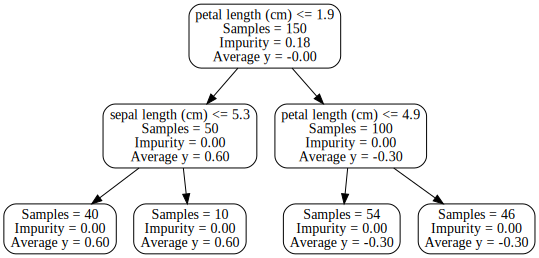

In [11]:
iris_sample_vals = iris_sample.values

# # for small sample
# X = iris_sample_vals[:,:-1]
# y = iris_sample_vals[:,-1]

X = iris_df.values[:,:-1]
y = iris_df.values[:,-1]

gbdt = GradientBoostedDecisionTree(n_classes=3, n_trees=4)
gbdt.fit(X, y)

feature_names = iris_data['feature_names']
gbdt.render(stage=3, class_k=0, feature_names=feature_names)

### Example prediction on Iris data set

In [12]:
gbdt.predict_proba(X[0:4,:])

array([[0.29276876, 0.41410537, 0.29312588],
       [0.42221886, 0.28880079, 0.28898035],
       [0.28885716, 0.29160327, 0.41953957],
       [0.29276876, 0.41410537, 0.29312588]])

In [13]:
gbdt.predict(X)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 1, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0,
       1, 2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0,
       0, 2, 1, 2, 1, 1, 2, 1, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1,
       1, 2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 1,
       0, 2, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 1, 0, 1, 2])

In [14]:
y.astype(int)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0,
       1, 2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1,
       1, 2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2,
       0, 2, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 2])

## Gradient boosted decision tree classifier - Titanic data

### Load titanic data set

In [15]:
X_train = pd.read_feather('../data/titanic/processed/X_train.feather')
y_train = pd.read_feather('../data/titanic/processed/y_train.feather')
X_test = pd.read_feather('../data/titanic/processed/X_test.feather')
y_test = pd.read_feather('../data/titanic/processed/y_test.feather')

### Gradient boosted decision tree model accuracy on Titanic data

In [17]:
logger.setLevel(logging.WARNING)
titanic_gbdt = GradientBoostedDecisionTree(max_depth=8, n_trees=10, learning_rate=0.5)
titanic_gbdt.fit(X_train.values, y_train.values)
y_pred = titanic_gbdt.predict(X_test.values)
test_acc = (y_pred.flatten() == y_test.values.flatten()).sum() / len(y_test)
print(f'Test accuracy = {test_acc:.2%}')

Test accuracy = 83.24%


## Gradient boosted decision tree regressor - Boston housing data

### Load Boston housing data

In [18]:
boston_data = load_boston()
boston_df = pd.DataFrame(boston_data['data'], columns=boston_data['feature_names'])
boston_df['y'] = boston_data['target']
boston_df = boston_df.sample(frac=1, random_state=42).reset_index(drop=True)
boston_sample = boston_df.head(5)
boston_sample

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,0.09178,0.0,4.05,0.0,0.510,6.416,84.1,2.6463,5.0,296.0,16.6,395.50,9.04,23.6
1,0.05644,40.0,6.41,1.0,0.447,6.758,32.9,4.0776,4.0,254.0,17.6,396.90,3.53,32.4
2,0.10574,0.0,27.74,0.0,0.609,5.983,98.8,1.8681,4.0,711.0,20.1,390.11,18.07,13.6
3,0.09164,0.0,10.81,0.0,0.413,6.065,7.8,5.2873,4.0,305.0,19.2,390.91,5.52,22.8
4,5.09017,0.0,18.10,0.0,0.713,6.297,91.8,2.3682,24.0,666.0,20.2,385.09,17.27,16.1


### Fit gradient boosted decision tree on Boston data

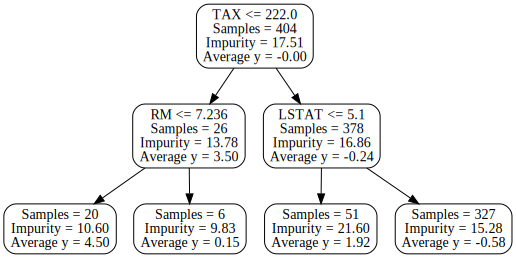

In [19]:
X = boston_df.values[:,:-1]
y = boston_df.values[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
boston_gbdt = GradientBoostedDecisionTree(
    is_classifier=False,
    n_classes=1,
    n_trees=20,
    max_depth=2)
boston_gbdt.fit(X_train, y_train)

boston_feature_names = boston_data['feature_names']
boston_gbdt.render(9,0,feature_names=boston_feature_names)

### Gradient boosted decision tree accuracy on Boston data

In [20]:
y_pred = boston_gbdt.predict(X_test)
test_acc = r2_score(y_test, y_pred)
print(f'Test accuracy (R2 score) = {test_acc:.2%}')

Test accuracy (R2 score) = 71.64%


## End